## ARCH model

The ARCH model is widely used to model financial return time series. 
We always denote a generic time series by $(Y_t)$.
ARCH model is a specification of the conditional variance of $Y_t$ given its history $\mathcal F_{t-1}$
by the following equation: 
$$\mathrm{Var}[Y_t| \mathcal F_{t-1}] = \omega + \alpha Y_{t-1}^2.$$

In code, it is straightforward to define the ARCH model with the `arch` library. 

## `arch` library

In [51]:
import numpy as np
from arch import arch_model

In [52]:
rng = np.random.default_rng(41)
y = rng.normal(0,np.arange(500)*0.2,size=(500,))
mod = arch_model(y)
res = mod.fit(disp="off")
fcst = res.forecast(horizon=50, method="bootstrap", simulations=3)

Above  we exposed the main classes of the library.    
- `arch_model` is a convenience model constructor function with which one can specify the the mean process, the volatility (aka conditional standard deviation), the noise distribution (adhere to `scipy.stats`)  
- `mod.fit()` resturns a result container: one can inspect residuals, standardised residuals, volatilities of the fit model.  
- `res.forecast()` resturns a forecast container: one can make forecast of future paths, future conditonal variance etc. 

In [56]:
type(mod), type(res), type(fcst)

(arch.univariate.mean.ConstantMean,
 arch.univariate.base.ARCHModelResult,
 arch.univariate.base.ARCHModelForecast)

In [53]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2532.85
Distribution:                  Normal   AIC:                           5073.70
Method:            Maximum Likelihood   BIC:                           5090.56
                                        No. Observations:                  500
Date:                Sun, Sep 15 2024   Df Residuals:                      499
Time:                        22:22:08   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0534      0.643 -8.301e-02      0.934 [ -1.313,  1.206]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.1340      1.024      1.107      0.268 [ -0.874,  3.141]
alpha[1]       0.0605      0.151      0.400      0.689 [ -0.236,  0.357]
beta[1]        0.9395      0.200      4.705  2.534e-06 [  0.548,  1.331]
========================================================================

Covariance estimator: robust
"""

:NdOverlay   [Variable]
   :Curve   [index]   (value)
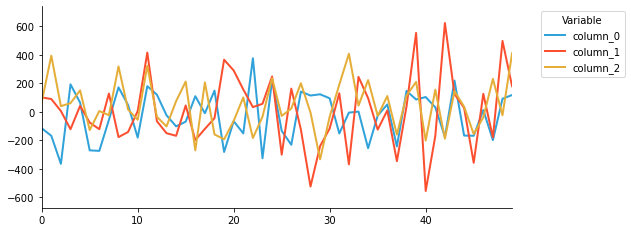

In [54]:
import polars as pl
import hvplot.polars
hvplot.extension('matplotlib')

pl.DataFrame(fcst.simulations.values.squeeze().T).hvplot() # 3 forecasted paths with horizon 50

## Zooming in the result summary

There are plenty of information in the summary. Most of them should be self-explanatory if one is familiar with basic terminology of statistical inference. Notice that the model we defind is `GARCH`, where "G" stands for "Generalised". A typical GARCH process is GARCH(1,1) defined through the specification: 
$$\mathrm{Var}[Y_t| \mathcal F_{t-1}] = \omega + \alpha Y_{t-1}^2 + \beta \mathrm{Var}[Y_{t-1}| \mathcal F_{t-2}].$$
